# Part 1: Feature Extraction

In [1]:
!pip install kagglehub tqdm

import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm


In [2]:
import kagglehub

dataset_path = kagglehub.dataset_download("adityajn105/flickr30k")

print("Dataset downloaded to:", dataset_path)
print("Top-level contents:", os.listdir(dataset_path))


Dataset downloaded to: /kaggle/input/datasets/adityajn105/flickr30k
Top-level contents: ['captions.txt', 'Images']


In [3]:
def locate_dataset_components(root_dir):
    image_dir = None
    caption_file = None
    
    for root, dirs, files in os.walk(root_dir):
        
        # Look for captions file
        for file in files:
            if file.lower().startswith("caption") and file.endswith(".txt"):
                caption_file = os.path.join(root, file)
        
        # Detect folder containing many images
        jpg_files = [f for f in files if f.lower().endswith(".jpg")]
        if len(jpg_files) > 1000:
            image_dir = root
    
    return image_dir, caption_file


IMAGE_DIR, CAPTION_PATH = locate_dataset_components(dataset_path)

print("Images found at:", IMAGE_DIR)
print("Captions file found at:", CAPTION_PATH)

if IMAGE_DIR is None or CAPTION_PATH is None:
    raise RuntimeError("Dataset structure not detected properly.")


Images found at: /kaggle/input/datasets/adityajn105/flickr30k/Images/flickr30k_images
Captions file found at: /kaggle/input/datasets/adityajn105/flickr30k/captions.txt


In [4]:
class ImageFeatureDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        
        self.image_files = [
            f for f in os.listdir(image_folder)
            if f.lower().endswith((".jpg", ".jpeg"))
        ]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        filename = self.image_files[index]
        full_path = os.path.join(self.image_folder, filename)
        
        image = Image.open(full_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, filename


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Remove final classification layer
feature_layers = list(resnet.children())[:-1]
feature_extractor = nn.Sequential(*feature_layers)

feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

print("Feature extractor ready.")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Feature extractor ready.


In [7]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])


In [8]:
dataset = ImageFeatureDataset(IMAGE_DIR, transform=image_transform)
loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

cached_features = {}

with torch.no_grad():
    for batch_images, batch_names in tqdm(loader, desc="Extracting Image Features"):
        
        batch_images = batch_images.to(device)
        output = feature_extractor(batch_images)
        
        output = output.view(output.size(0), -1)  # Flatten 2048
        
        for i, name in enumerate(batch_names):
            cached_features[name] = output[i].cpu().numpy()

print("Total images processed:", len(cached_features))


Extracting Image Features: 100%|██████████| 249/249 [03:36<00:00,  1.15it/s]

Total images processed: 31783


In [9]:
output_file = "flickr30k_resnet50_features.pkl"

with open(output_file, "wb") as f:
    pickle.dump(cached_features, f)

print("Feature file saved as:", output_file)


Feature file saved as: flickr30k_resnet50_features.pkl


# Part 2: Vocabulary + Text preprocessing

In [10]:
import re
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

def load_captions(caption_path):
    image_to_captions = {}
    
    with open(caption_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    
    # Skip header if present
    for line in lines[1:]:
        parts = line.strip().split(",", 1)
        if len(parts) != 2:
            continue
        
        image_name, caption = parts
        image_name = image_name.split("#")[0]
        
        if image_name not in image_to_captions:
            image_to_captions[image_name] = []
        
        image_to_captions[image_name].append(caption)
    
    return image_to_captions


image_caption_map = load_captions(CAPTION_PATH)

print("Total images with captions:", len(image_caption_map))


Total images with captions: 31783


In [12]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)   # remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [13]:
class VocabularyBuilder:
    def __init__(self, min_freq=5):
        self.min_freq = min_freq
        
        self.pad_token = "<pad>"
        self.start_token = "<start>"
        self.end_token = "<end>"
        self.unk_token = "<unk>"
        
        self.word2idx = {}
        self.idx2word = {}
    
    def build(self, caption_dict):
        counter = Counter()
        
        for captions in caption_dict.values():
            for caption in captions:
                cleaned = normalize_text(caption)
                counter.update(cleaned.split())
        
        vocab_words = [
            word for word, freq in counter.items()
            if freq >= self.min_freq
        ]
        
        all_tokens = [
            self.pad_token,
            self.start_token,
            self.end_token,
            self.unk_token
        ] + vocab_words
        
        for idx, token in enumerate(all_tokens):
            self.word2idx[token] = idx
            self.idx2word[idx] = token
        
        print("Vocabulary size:", len(self.word2idx))
    
    def encode(self, sentence):
        tokens = normalize_text(sentence).split()
        encoded = [self.word2idx.get(word, self.word2idx[self.unk_token]) for word in tokens]
        return encoded


In [14]:
vocab = VocabularyBuilder(min_freq=5)
vocab.build(image_caption_map)

PAD_ID = vocab.word2idx["<pad>"]
START_ID = vocab.word2idx["<start>"]
END_ID = vocab.word2idx["<end>"]


Vocabulary size: 7689


In [15]:
def create_training_samples(feature_dict, caption_dict, vocab):
    samples = []
    
    for image_name, captions in caption_dict.items():
        if image_name not in feature_dict:
            continue
        
        image_vector = torch.tensor(feature_dict[image_name], dtype=torch.float32)
        
        for caption in captions:
            encoded = vocab.encode(caption)
            
            # Add start and end tokens
            encoded = [START_ID] + encoded + [END_ID]
            
            samples.append((image_vector, torch.tensor(encoded)))
    
    return samples


training_samples = create_training_samples(cached_features, image_caption_map, vocab)

print("Total caption samples:", len(training_samples))


Total caption samples: 158915


In [16]:
class CaptionDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]


In [18]:
def caption_collate_fn(batch):
    image_vectors = []
    caption_sequences = []
    
    for img_vec, caption in batch:
        image_vectors.append(img_vec)
        caption_sequences.append(caption)
    
    image_vectors = torch.stack(image_vectors)
    padded_captions = pad_sequence(
        caption_sequences,
        batch_first=True,
        padding_value=PAD_ID
    )
    
    return image_vectors, padded_captions


In [19]:
caption_dataset = CaptionDataset(training_samples)

caption_loader = DataLoader(
    caption_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=caption_collate_fn
)

print("Caption DataLoader ready.")


Caption DataLoader ready.


# Part 3: Encoder + Decoder architecture

encoder

In [21]:
class ImageEncoder(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=512):
        super(ImageEncoder, self).__init__()
        self.projection = nn.Linear(input_dim, hidden_dim)
    
    def forward(self, image_features):
        projected = self.projection(image_features)
        return projected


decoder

In [22]:
class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512):
        super(CaptionDecoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, captions, hidden_state):
        embeddings = self.embedding(captions)
        
        outputs, _ = self.lstm(embeddings, hidden_state)
        
        logits = self.output_layer(outputs)
        
        return logits


In [23]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim=512):
        super(ImageCaptioningModel, self).__init__()
        
        self.encoder = ImageEncoder(input_dim=2048, hidden_dim=hidden_dim)
        self.decoder = CaptionDecoder(
            vocab_size=vocab_size,
            embed_dim=256,
            hidden_dim=hidden_dim
        )
    
    def forward(self, image_features, captions):
        
        # Encode image
        encoded = self.encoder(image_features)
        
        # Initialize
        h0 = encoded.unsqueeze(0)   # shape: (1, batch, hidden)
        c0 = torch.zeros_like(h0)
        
        # teacher forcing
        captions_input = captions[:, :-1]
        
        logits = self.decoder(captions_input, (h0, c0))
        
        return logits


In [24]:
vocab_size = len(vocab.word2idx)

model = ImageCaptioningModel(vocab_size=vocab_size).to(device)

print("Model initialized.")


Model initialized.


# Part 4: Training & Inference

In [25]:
from sklearn.model_selection import train_test_split

train_samples, val_samples = train_test_split(
    training_samples,
    test_size=0.1,
    random_state=42
)

train_dataset = CaptionDataset(train_samples)
val_dataset = CaptionDataset(val_samples)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=caption_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=caption_collate_fn
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 2235
Val batches: 249


In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [27]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    
    for images, captions in loader:
        images = images.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images, captions)
        
        targets = captions[:, 1:]  # shift right
        
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            targets.reshape(-1)
        )
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


In [28]:
def validate(model, loader):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, captions in loader:
            images = images.to(device)
            captions = captions.to(device)
            
            outputs = model(images, captions)
            targets = captions[:, 1:]
            
            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                targets.reshape(-1)
            )
            
            total_loss += loss.item()
    
    return total_loss / len(loader)


In [29]:
num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = validate(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")


Epoch 1/5
Train Loss: 3.5966
Val Loss: 3.1445
Epoch 2/5
Train Loss: 2.9640
Val Loss: 2.9589
Epoch 3/5
Train Loss: 2.7400
Val Loss: 2.8968
Epoch 4/5
Train Loss: 2.5836
Val Loss: 2.8767
Epoch 5/5
Train Loss: 2.4571
Val Loss: 2.8854


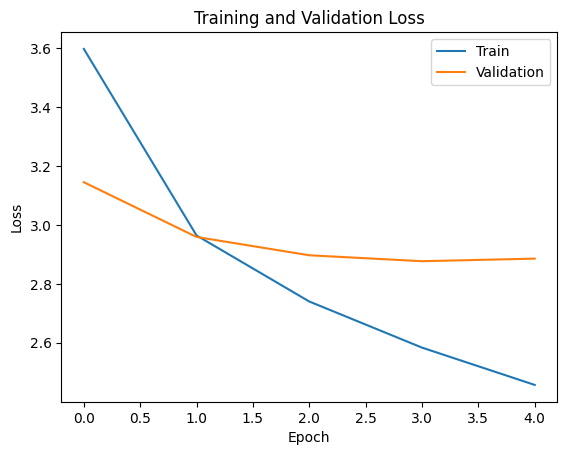

In [30]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.title("Training and Validation Loss")
plt.show()


In [31]:
def greedy_caption(model, image_feature, max_length=20):
    model.eval()
    
    image_feature = image_feature.unsqueeze(0).to(device)
    
    with torch.no_grad():
        encoded = model.encoder(image_feature)
        h = encoded.unsqueeze(0)
        c = torch.zeros_like(h)
        
        current_token = torch.tensor([[START_ID]]).to(device)
        
        generated = []
        
        for _ in range(max_length):
            embeddings = model.decoder.embedding(current_token)
            output, (h, c) = model.decoder.lstm(embeddings, (h, c))
            logits = model.decoder.output_layer(output.squeeze(1))
            
            next_token = logits.argmax(dim=-1)
            
            token_id = next_token.item()
            
            if token_id == END_ID:
                break
            
            generated.append(token_id)
            
            current_token = next_token.unsqueeze(0)
        
    words = [vocab.idx2word[idx] for idx in generated]
    return " ".join(words)


beam search

In [33]:
import torch.nn.functional as F

def beam_search_caption(model, image_feature, beam_width=3, max_length=20):
    model.eval()
    
    image_feature = image_feature.unsqueeze(0).to(device)
    
    with torch.no_grad():
        encoded = model.encoder(image_feature)
        h = encoded.unsqueeze(0)
        c = torch.zeros_like(h)
        
        sequences = [([START_ID], 0.0, h, c)]
        
        for _ in range(max_length):
            all_candidates = []
            
            for seq, score, h, c in sequences:
                current_token = torch.tensor([[seq[-1]]]).to(device)
                
                embeddings = model.decoder.embedding(current_token)
                output, (h_new, c_new) = model.decoder.lstm(embeddings, (h, c))
                logits = model.decoder.output_layer(output.squeeze(1))
                
                log_probs = F.log_softmax(logits, dim=-1)
                
                topk_probs, topk_ids = log_probs.topk(beam_width)
                
                for i in range(beam_width):
                    candidate = (
                        seq + [topk_ids[0][i].item()],
                        score + topk_probs[0][i].item(),
                        h_new,
                        c_new
                    )
                    all_candidates.append(candidate)
            
            sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        
        best_sequence = sequences[0][0]
    
    words = [
        vocab.idx2word[idx]
        for idx in best_sequence
        if idx not in (START_ID, END_ID)
    ]
    
    return " ".join(words)


BLEU + Precision + Recall + F1

In [34]:
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_sample(image_feature, reference_caption):
    predicted = greedy_caption(model, image_feature)
    
    reference_tokens = normalize_text(reference_caption).split()
    predicted_tokens = predicted.split()
    
    bleu = sentence_bleu([reference_tokens], predicted_tokens)
    
    # Token-level binary evaluation
    ref_set = set(reference_tokens)
    pred_set = set(predicted_tokens)
    
    all_words = list(ref_set.union(pred_set))
    
    ref_binary = [1 if w in ref_set else 0 for w in all_words]
    pred_binary = [1 if w in pred_set else 0 for w in all_words]
    
    precision = precision_score(ref_binary, pred_binary)
    recall = recall_score(ref_binary, pred_binary)
    f1 = f1_score(ref_binary, pred_binary)
    
    return bleu, precision, recall, f1


part 5: show 5 caption examples

In [35]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_predictions(num_examples=5):
    model.eval()
    
    samples = random.sample(val_samples, num_examples)
    
    for img_feature, caption_tensor in samples:
        
        # Get original image filename
        # We must find image name from feature dict
        for name, feat in cached_features.items():
            if torch.allclose(torch.tensor(feat), img_feature, atol=1e-6):
                image_name = name
                break
        
        image_path = os.path.join(IMAGE_DIR, image_name)
        image = Image.open(image_path)
        
        generated_caption = greedy_caption(model, img_feature)
        
        # Decode ground truth
        gt_tokens = [
            vocab.idx2word[idx.item()]
            for idx in caption_tensor
            if idx.item() not in (PAD_ID, START_ID, END_ID)
        ]
        ground_truth = " ".join(gt_tokens)
        
        plt.figure(figsize=(4,4))
        plt.imshow(image)
        plt.axis("off")
        plt.title("Ground Truth:\n" + ground_truth + "\n\nGenerated:\n" + generated_caption)
        plt.show()


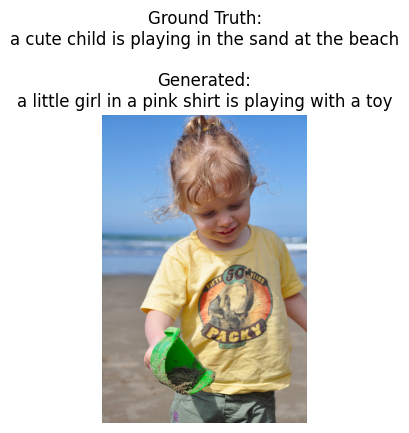

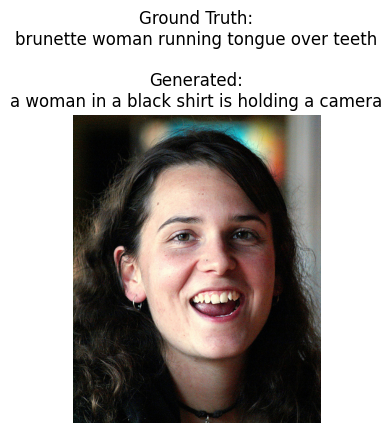

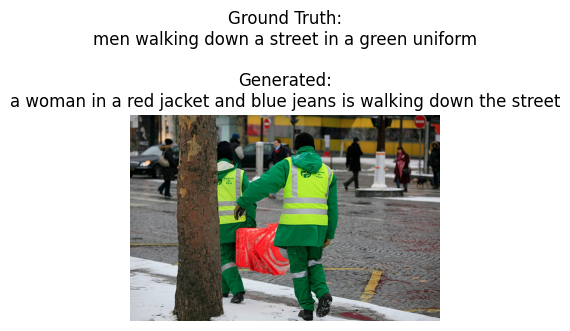

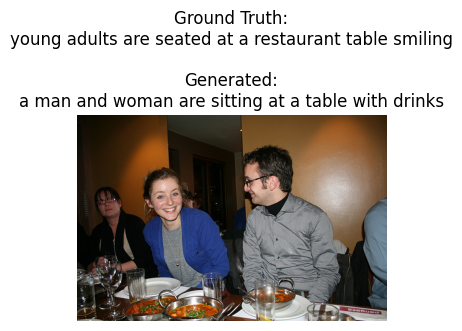

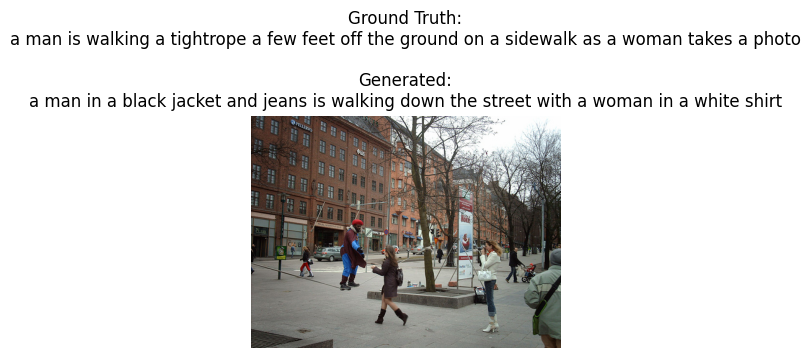

In [36]:
show_predictions(5)


Evaluate Average Metrics on Validation

In [37]:
def evaluate_model(num_samples=100):
    bleu_scores = []
    precisions = []
    recalls = []
    f1s = []
    
    samples = random.sample(val_samples, num_samples)
    
    for img_feature, caption_tensor in samples:
        gt_tokens = [
            vocab.idx2word[idx.item()]
            for idx in caption_tensor
            if idx.item() not in (PAD_ID, START_ID, END_ID)
        ]
        ground_truth = " ".join(gt_tokens)
        
        bleu, p, r, f1 = evaluate_sample(img_feature, ground_truth)
        
        bleu_scores.append(bleu)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    
    print("BLEU-4:", sum(bleu_scores)/len(bleu_scores))
    print("Precision:", sum(precisions)/len(precisions))
    print("Recall:", sum(recalls)/len(recalls))
    print("F1:", sum(f1s)/len(f1s))


In [38]:
evaluate_model()


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU-4: 0.018337343420813425
Precision: 0.32666724941724945
Recall: 0.31364027183686627
F1: 0.305905085794526


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

grad\io app

In [39]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 12.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.8 MB/s eta 0:00:0000:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.5
    Uninstalling pydantic_core-2.41.5:
      Successfully uninstalled pydantic_core-2.41.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.5
    Uninstalling pydantic-2.12.5:
      Successfully uninstalled pydantic-2.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
langchain-core 0.3.79 requires packaging<26.0.0,>=23.2.0, but you have packaging 26.0rc2 which is incompatible.
fastai 2.8.4 requires fastcore

In [40]:
import gradio as gr

def caption_uploaded_image(image):
    image = image.convert("RGB")
    image_tensor = image_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = feature_extractor(image_tensor)
        features = features.view(1, -1)
    
    caption = greedy_caption(model, features.squeeze(0))
    
    return caption

interface = gr.Interface(
    fn=caption_uploaded_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Neural Storyteller - Image Captioning",
    description="Upload an image to generate a caption."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://47763b268e414e14c6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
